In [1]:
%load_ext autoreload
%autoreload 2

Import modules

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import QMDataset

from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm

from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis_OLD, _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks_OLD, matrix_to_blocks

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.to(arrays='numpy')
    blocks = sort(blocks)
    blocks = blocks.to(arrays='torch')
    
    coupled_blocks = coupled_blocks.to(arrays='numpy')
    coupled_blocks = sort(coupled_blocks)
    coupled_blocks = coupled_blocks.to(arrays='torch')
    
    return blocks, coupled_blocks

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

In [4]:
orbitals = {
    'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]}
}

In [5]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
# ORBS = 'gthszvmolopt'
START = 0
STOP = 2
frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True] 
    f.wrap(center=(0.,0.,0.))

kmesh = [12,12,1]

kfock = np.load(f"{root}/c2/aims/H_k.npz")
kfock = [kfock[arr] for arr in kfock.files[slice(START, STOP)]]

# from copy import deepcopy
# kfock_ = deepcopy(kfock)

# Ts = np.load(f"{root}/c2/aims/cell_idx_list.npz")
# rfock = np.load(f"{root}/c2/aims/realspaceH_nonsym.npz")
# rfock = [{tuple(int(t) for t in T): rf for T, rf in zip(Ts[arr], rfock[arr])} for arr in rfock.files[slice(START, STOP)]]
# rover = np.load(f"{root}/c2/aims/realspaceOvl_nonsym.npz")
# rover = [{tuple(int(t) for t in T): rf for T, rf in zip(Ts[arr], rover[arr])} for arr in rover.files[slice(START, STOP)]]

dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2, 
                               fix_p_orbital_order = False,
                               apply_condon_shortley = True,
                               # fock_realspace = rfock,
                               # overlap_realspace = rover,
                               fock_kspace = kfock,
                               # overlap_kspace = kover,
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = ORBS)

/home/pegolo/Software/mlelec/src/mlelec/data/dataset.py:872: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


# Targets

In [6]:
from metatensor import sort
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)

In [7]:
from mlelec.utils.pbc_utils import kmatrix_to_blocks
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False)

# Features

In [14]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline
max_radial  = 8
max_angular = 5
atomic_gaussian_width = 0.3
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

def compute_features(dataset):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = None, 
                          T_dict = None)  
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [15]:
hfeat = compute_features(dataset)

# Train

## Ridge regression

In [16]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [11]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [12]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -2, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(4.0980e-05)


Compute the feature covariance matrix and diagonalize it. Project the weights onto the covariance eigenstates at each training iteration (TODO)

## Torch

In [17]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [18]:
from mlelec.models.linear import LinearModelPeriodic

In [19]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
target_kspace = dataset.fock_kspace #orch.stack([kfock[ifr][:1] for ifr in range(3)])
CG = ClebschGordanReal(lmax = 3, device = device)

In [20]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 512, 
                            nlayers = 1,
                            train_kspace = False,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()
# for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
#     p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
last_layer_kernel = {}
nepoch = 500

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    # optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 1e-1)) #, betas = (0.8, 0.9)))
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-3, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))

In [21]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

phase, indices = precompute_phase(target_blocks, dataset, cutoff = cutoff)

loss_real = []
loss_k = []

new_sched = True
for epoch in range(nepoch):

    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    
    pred = model()
    unc_pred = _to_uncoupled_basis(pred, cg = CG)
    pred_kspace = TMap_bloch_sums(unc_pred, phase, indices)
    
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 0:

        # Compute the loss for each block
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)

        # Total loss
        epoch_loss = epoch_loss.item()
        
        # Append the values of the loss to a list
        loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 2*12*12).item())
        loss_real.append(epoch_loss)

        # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
                
    else:

        # Compute the loss
        loss = L2_loss(pred_kspace, k_target_blocks, norm = 2*12*12)

        # Total loss 
        epoch_loss = loss.item()
        
        # Append the values of the loss to a list
        loss_real.append(L2_loss(pred, target_coupled_blocks).item())
        loss_k.append(epoch_loss)

        loss.backward(retain_graph = True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        for ik, key in enumerate(model.model):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss/len(model.model))
        
    if epoch % 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss real  472.3191662686, train loss k  437.9705932919, train loss per prediction 3.32186e-03
Epoch      10, train loss real  145.2168755370, train loss k  144.6484815456, train loss per prediction 1.90905e-03
Epoch      20, train loss real    0.3794703421, train loss k    0.2756040143, train loss per prediction 8.33302e-05
Epoch      30, train loss real    0.6459917496, train loss k    0.5581449209, train loss per prediction 1.18586e-04
Epoch      40, train loss real    0.2836925200, train loss k    0.2481200235, train loss per prediction 7.90661e-05
Epoch      50, train loss real    0.2107573787, train loss k    0.2004642786, train loss per prediction 7.10686e-05
Epoch      60, train loss real    0.1115143833, train loss k    0.1017572025, train loss per prediction 5.06340e-05
Epoch      70, train loss real    0.1547327027, train loss k    0.1400800979, train loss per prediction 5.94084e-05
Epoch      80, train loss real    0.1140014904, train loss k    0.109173

In [17]:
# from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
# from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums
# # kpts_ = torch.from_numpy(np.array(kpts_train)).to(device)

# phase, where_inv = precompute_phase(target_blocks, dataset, cutoff = cutoff)

# loss_real = []
# loss_k = []

# new_sched = True
# for epoch in range(nepoch):

#     model.train(True)

#     for ik, key in enumerate(model.model):
#         optimizers[ik].zero_grad()
    
#     pred = model()
#     n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

#     if epoch < 100:
#         all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)
#         epoch_loss = epoch_loss.item()
#         for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
#             loss.backward(retain_graph = False)
#             torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
#             optimizers[ik].step()
#             # schedulers[ik].step()
#             schedulers[ik].step(loss)
            
#             if key not in losses:
#                 losses[key] = [loss.item()]
#                 learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
#             else:
#                 losses[key].append(loss.item())
#                 learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
            
#         unc_pred = _to_uncoupled_basis(pred, cg = CG)
#         pred_kspace = TMap_bloch_sums(unc_pred, phase, where_inv)
#         loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 2*144).item())
#         loss_real.append(epoch_loss)
#         # for ik, (key, loss) in enumerate(model.model):
        
#     else:
#         # if new_sched:
#         #     pred_before_k = pred.copy()

#         #     optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
#         #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 200, verbose=True)
#         #     # for s, o in zip(schedulers, optimizers):
#         #     #     s = torch.optim.lr_scheduler.ReduceLROnPlateau(o, factor = 0.5, patience = 100, verbose=True)
#         #     new_sched = False

#         #     _loss = L2_kspace_loss(pred, 
#         #                       target_kspace, 
#         #                       dataset, 
#         #                       cg = CG, 
#         #                       kpts = kpts_,
#         #                       norm = 1
#         #                       )
#         #     print("Initial k-space loss = ", _loss.item())

#         unc_pred = _to_uncoupled_basis(pred, cg = CG)
#         pred_kspace = TMap_bloch_sums(unc_pred, phase, where_inv)
#         loss = L2_loss(pred_kspace, k_target_blocks, norm = 2*144)
#         loss_real.append(L2_loss(pred, target_coupled_blocks).item())
#         # pred_kspace = None # Allow to deallocate
#         # loss = L2_kspace_loss(pred, 
#         #               target_kspace, 
#         #               dataset, 
#         #               cg = CG, 
#         #               kpts = kpts_,
#         #               norm = 1
#         #               ) 

#         loss.backward(retain_graph = False)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
#         epoch_loss = loss.item()

#         loss_k.append(epoch_loss)
#         # for key in model.model:
#         #     if key not in losses:
#         #         losses[key] = [epoch_loss/len(model.model)]
#         #     else:
#         #         losses[key].append(epoch_loss/len(model.model))
    
#         for ik, key in enumerate(model.model):
#             optimizers[ik].step()
#             schedulers[ik].step(epoch_loss)
        
#         # optimizer.step()
#         # scheduler.step(epoch_loss)

#     # for i, key in enumerate(model.model):
#     #     if key not in para:
#     #         para[key] = {}
#     #         # grad[key] = []
#     #         # optimizers[0].param_groups[0]['lr']
#     #     for i, param in enumerate(model.model[key].parameters()):
#     #         # grad[key].append(param.grad.norm().item())
#     #         if i not in para[key]:
#     #             para[key][i] = []
#     #         para[key][i].append(torch.clone(param).detach())

#     # for k in model.target_blocks.keys:
#     #     kl = tuple(k.values)
#     #     if kl not in last_layer_kernel:
#     #         last_layer_kernel[kl] = []
#     #     feat = map_targetkeys_to_featkeys(hfeat, k)
#     #     m = model.model[str(kl)].mlp[:-1].forward(feat.values).detach()
#     #     # if epoch == 0:
#     #     #     print(kl, m.shape)
#     #     # m = m.reshape(-1, m.shape[-1])
#     #     mTm = torch.einsum('scf,Scf->csS', m, m)
#     #     # mTm = torch.einsum('scf,scg->cfg', m, m)
#     #     last_layer_kernel[kl].append(mTm)
    
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

#         # for i, key in enumerate(model.model):
#         #     if key not in para:
#         #         para[key] = []
#         #         grad[key] = []
#         #         # optimizers[0].param_groups[0]['lr']
#         #     for param in model.model[key].parameters():
#         #         grad[key].append(param.grad.norm().item())
#         #         para[key].append(param.norm().item())

#     #     # validate 
#     #     valpred = model.predict(hfeat_test, target_test)
#     #     if loss_func == 'kspace':
#     #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
#     #     else:
#     #         val_loss = L2_loss(valpred, target_test)
        
#     #     print(f"Epoch {epoch} val loss {val_loss}")


Epoch       0, train loss on all blocks  472.3191662686, train loss per prediction 3.44967e-03
Epoch      10, train loss on all blocks  144.9112405630, train loss per prediction 1.91078e-03
Epoch      20, train loss on all blocks    0.3937676111, train loss per prediction 9.96046e-05
Epoch      30, train loss on all blocks    0.4370468295, train loss per prediction 1.04936e-04
Epoch 00032: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00035: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00037: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00037: reducing learning rate of group 0 to 8.0000e-04.
Epoch      40, train loss on all blocks    1.9360444597, train loss per prediction 2.20860e-04
Epoch      50, train loss on all blocks    0.5686732944, train loss per prediction 1.19699e-04
Epoch 00058: reducing learning rate of group 0 to 8.0000e-04.
Epoch      60, train loss on all blocks    0.3829309893, train loss per prediction 9.82245e-05
Epoch 00063: reducing lea


KeyboardInterrupt



In [21]:
unc_pred = _to_uncoupled_basis(pred, cg = CG)
pred_kspace = TMap_bloch_sums(unc_pred, phase, where_inv)
L2_loss(pred_kspace, k_target_blocks, norm = 2*144).item()

423.99631527445854

Text(0, 0.5, 'Loss')

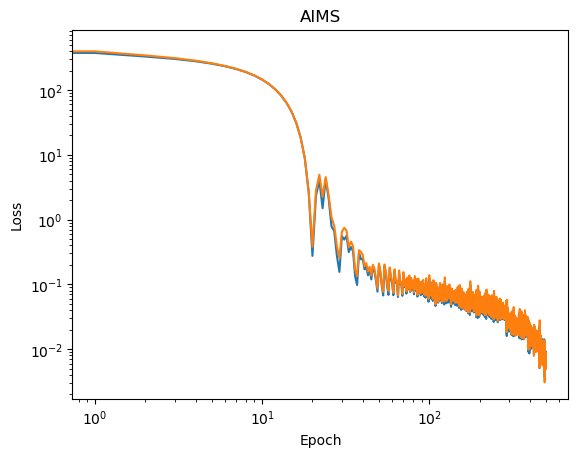

In [22]:
plt.loglog(loss_k, label='k')
plt.loglog(loss_real, label='real')
# plt.axhline(np.mean(np.array(loss_k)/np.array(loss_real)), label = f'avg ratio={np.mean(np.array(loss_k)/np.array(loss_real))}', ls = '--', color = 'k')
# plt.loglog(np.array(loss_k)/np.array(loss_real), label='ratio', color = 'gold')

# plt.legend()

plt.title('AIMS')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Bands

In [ ]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [ ]:
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 8.35, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 8.35)

In [ ]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 2
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[ifr].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[ifr].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[ifr]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_k], [rS_k], ['red'], ['--'], [1], ['after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    # if label == 'only real space':
        # continue
    realfock_cutoff = np.asarray(list(H[ifr].values()))
    realover_cutoff = np.asarray(list(S[ifr].values()))
    R_vec_rel = [list(T) for T in H[ifr]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



In [ ]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()